In [1]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import RR, nDCG, MAP

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

from common_helpers import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = "irds:beir/fiqa"
dataset = pt.get_dataset(dataset_path)
testset = pt.get_dataset(dataset_path + "/test")

In [3]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
)
index_ref = indexer.index(dataset.get_corpus_iter())

Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
beir/fiqa documents: 100%|██████████| 57638/57638 [00:10<00:00, 5353.07it/s]


In [4]:
# Models

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
dir = pt.terrier.Retriever(index_ref, wmodel="DirichletLM")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")
dfree = pt.terrier.Retriever(index_ref, wmodel="DFReeKLIM")

models = [bm25, dfree, pl2, dir]
metrics = [RR @ 10, nDCG @ 10, MAP @ 100]

In [5]:
# Add noise to the queries

# Retrieve test queries
test_queries = testset.get_topics()

# Add noise by deleting characters 10% of the time
aug = nac.OcrAug(aug_char_p=0.25, aug_word_p=0.7)

noisy_queries_df = add_query_noise(test_queries, aug)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

# Run the experiment
eval_result = pt.Experiment(
    models,
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=metrics
)

Original Query: where should i park my rainy day emergency fund
Noisy Query: wheke shoo1d i pakr my rainy day emergency fond
19:49:14.519 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
19:49:23.116 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
19:49:31.143 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
19:49:39.339 [main] WARN o

In [6]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results = []

for noise_level in noise_levels:
    aug = nac.OcrAug(aug_char_p=0.25, aug_word_p=noise_level, aug_word_min=0, aug_word_max=500000)
    noisy_queries_df = add_query_noise(test_queries, aug)

    print("Original query:", test_queries.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df.iloc[0]['query'])

    # Run retrieval experiment
    eval_result = pt.Experiment(
        models,
        noisy_queries_df,
        testset.get_qrels(),
        eval_metrics=metrics
    )

    # Store results
    eval_result["noise_level"] = noise_level
    results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
final_results.head(5)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where should i pakr my kainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke should i pakr my kainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke 8huuld i pakr my kainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where 8huuld i pakr my rainy day emek9ency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke sh0old i park my rainy day emek9ency fond
Original query: where should i park my rainy day emergency fund
Noisy query: wheke shoo1d i park my kainy day emek9ency fond


,name,RR@10,nDCG@10,AP@100,noise_level
0,TerrierRetr(BM25),0.310271,0.252589,0.208640,0.0
1,TerrierRetr(DFReeKLIM),0.315841,0.254521,0.208981,0.0
2,TerrierRetr(PL2),0.298390,0.241850,0.198975,0.0
3,TerrierRetr(DirichletLM),0.210783,0.177237,0.143839,0.0
4,TerrierRetr(BM25),0.271610,0.223835,0.185973,0.1


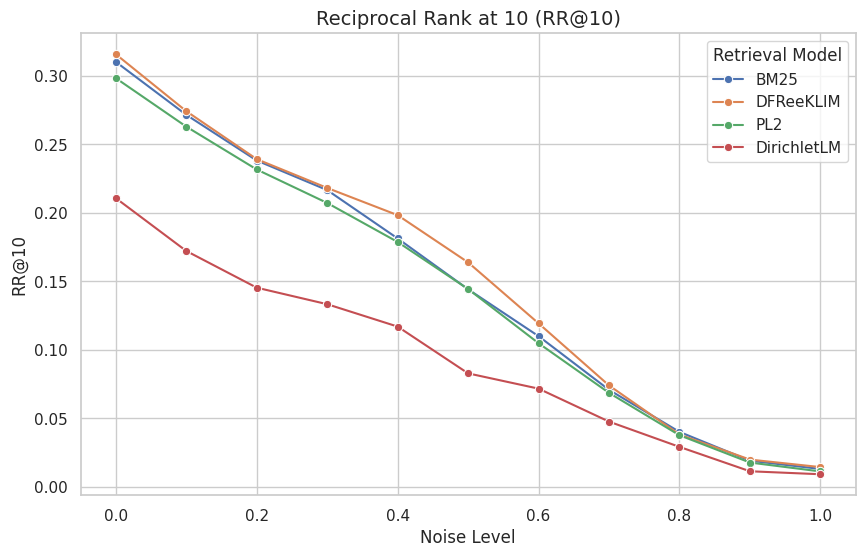

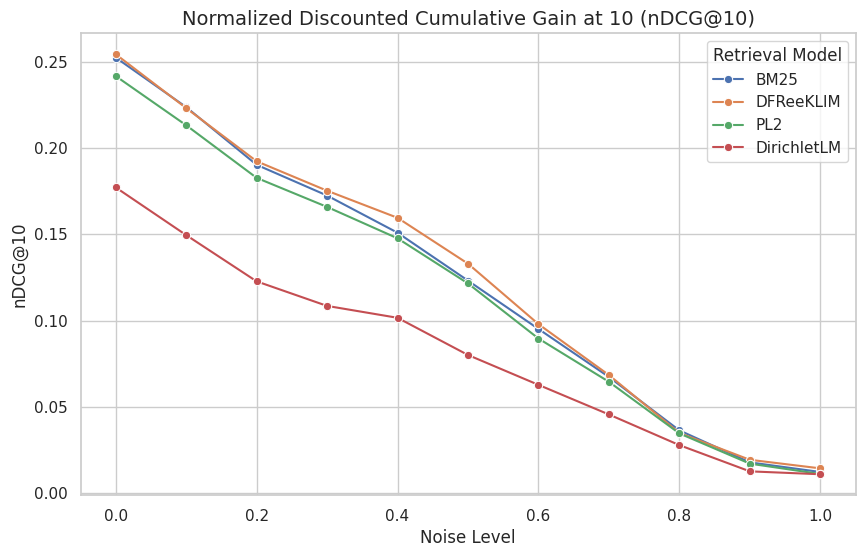

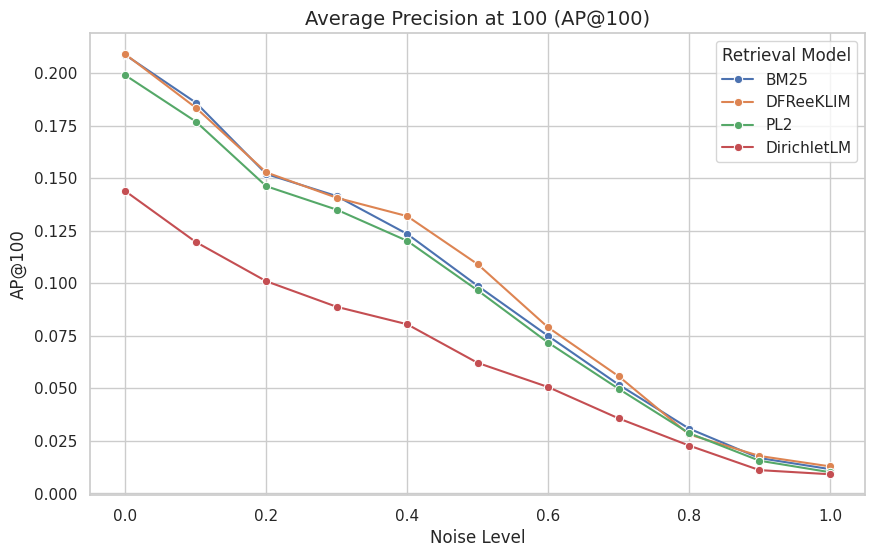

In [7]:
final_results["name"] = final_results["name"].str.extract(r"TerrierRetr\((.*?)\)")

# Plot all metrics with model comparison
plot_metric(final_results, "RR@10", "Reciprocal Rank at 10 (RR@10)", "Retrieval Model")
plot_metric(final_results, "nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)", "Retrieval Model")
plot_metric(final_results, "AP@100", "Average Precision at 100 (AP@100)", "Retrieval Model")

In [8]:
testset_2 = pt.get_dataset("irds:beir/fiqa/test")
test_queries_2 = testset_2.get_topics()

# Define noise levels
noise_levels_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results_2 = []

for noise_level in noise_levels_2:
    aug_2 = nac.KeyboardAug(aug_char_p=0.25, aug_word_p=noise_level, include_special_char=False, aug_word_min=0, aug_word_max=500000)
    noisy_queries_df_2 = add_query_noise(test_queries_2, aug_2)

    print("Original query:", test_queries_2.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df_2.iloc[0]['query'])

    # Run retrieval experiment
    eval_result_2 = pt.Experiment(
        models,
        noisy_queries_df_2,
        testset_2.get_qrels(),
        eval_metrics=metrics
    )

    # Store results
    eval_result_2["noise_level"] = noise_level
    results_2.append(eval_result_2)

# Combine results
final_results_2 = pd.concat(results_2, ignore_index=True)
final_results_2.head(5)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emerFrnvy fund
Original query: where should i park my rainy day emergency fund
Noisy query: where shiuid i park my rainy day ejerneBcy fund
Original query: where should i park my rainy day emergency fund
Noisy query: where should i oark my raKnj day emfrgenDu fund
Original query: where should i park my rainy day emergency fund
Noisy query: where syouPd i pqrk my daihy day emsrgSncg fund
Original query: where should i park my rainy day emergency fund
Noisy query: wyFre shoKlf i park my EainU day emRrgegfy fumd
Original query: where should i park my rainy day emergency fund
Noisy query: wUFre ehLuld i pSrk my 5ainh day emernend6 funw
Original query: where should i park my rainy day emergency fund
Noisy query: 2herF sh9ulv i pafk my 3aiby day emdrvdncy fInd


,name,RR@10,nDCG@10,AP@100,noise_level
0,TerrierRetr(BM25),0.310271,0.252589,0.208640,0.0
1,TerrierRetr(DFReeKLIM),0.315841,0.254521,0.208981,0.0
2,TerrierRetr(PL2),0.298390,0.241850,0.198975,0.0
3,TerrierRetr(DirichletLM),0.210783,0.177237,0.143839,0.0
4,TerrierRetr(BM25),0.236450,0.193527,0.157836,0.1


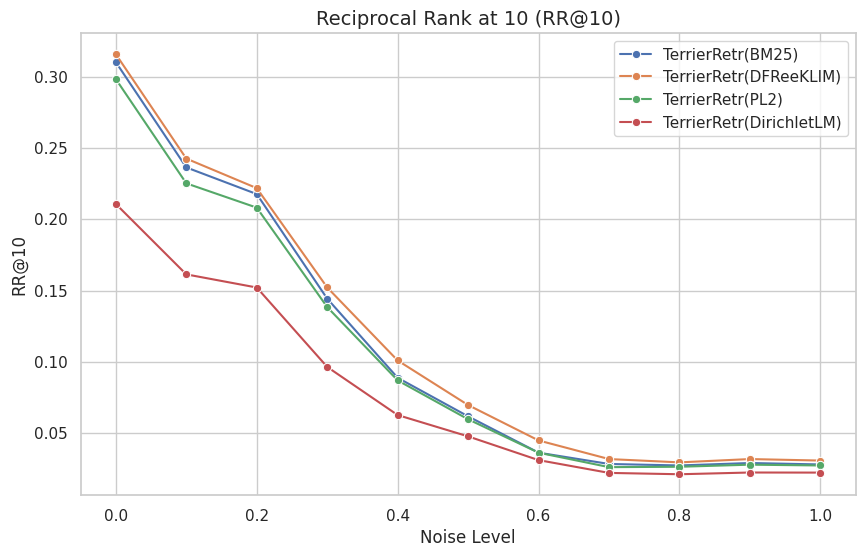

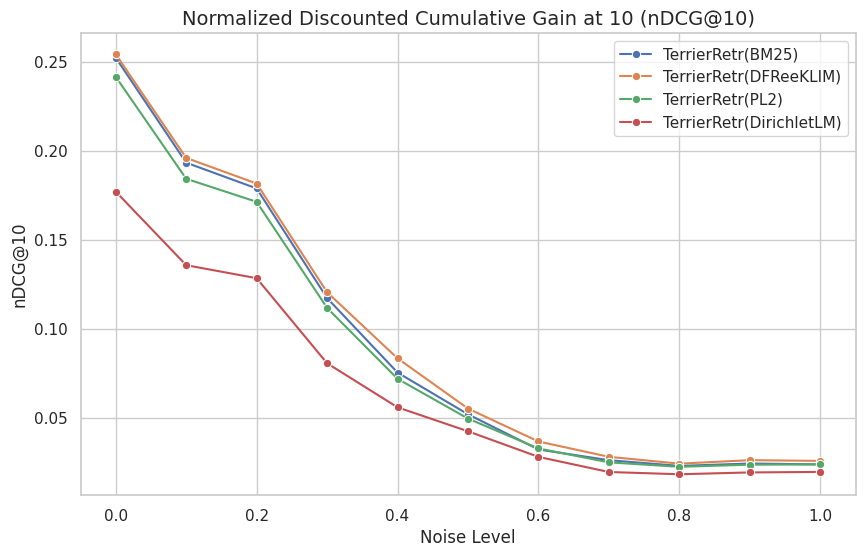

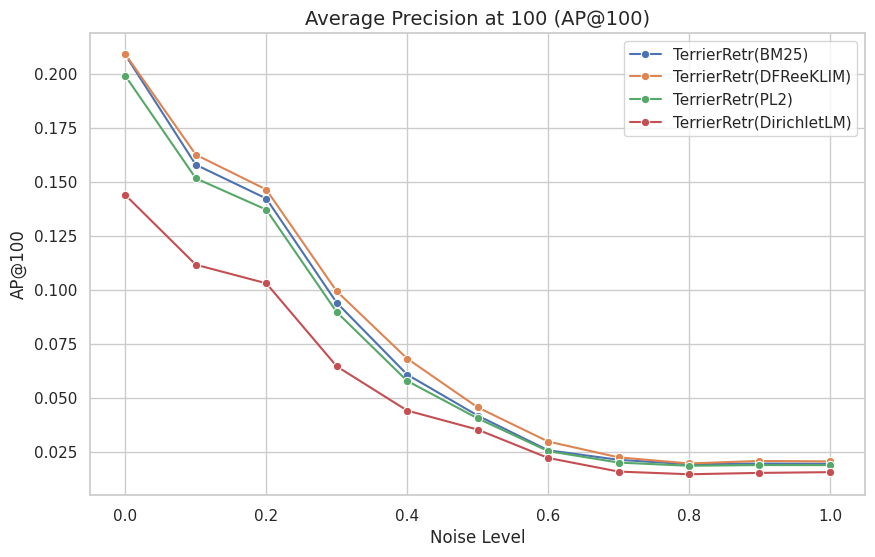

In [9]:
# final_results_2["name"] = final_results_2["name"].str.extract(r"TerrierRetr\((.*?)\)")

plot_metric(final_results_2, "RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric(final_results_2, "nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric(final_results_2, "AP@100", "Average Precision at 100 (AP@100)")